In [1]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_ollama import ChatOllama
from tqdm import tqdm
import os, psutil

In [2]:
!export KAGGLE_USERNAME=sharifbayev
!export KAGGLE_KEY=bb458b206d8bb9ab7c35ec53ca5676c2

In [3]:
import kagglehub
kagglehub.login()

path_1 = kagglehub.dataset_download("niyarrbarman/symptom2disease")

print("Path to dataset files:", path_1)

Path to dataset files: /Users/adon/.cache/kagglehub/datasets/niyarrbarman/symptom2disease/versions/1


In [4]:
import kagglehub

# Download latest version
path_2 = kagglehub.dataset_download("pawan2905/tweet-classification")

print("Path to dataset files:", path_2)

Path to dataset files: /Users/adon/.cache/kagglehub/datasets/pawan2905/tweet-classification/versions/1


In [5]:
import pandas as pd

In [6]:
df_1 = pd.read_csv(path_1+"/Symptom2Disease.csv")
df_2 = pd.read_csv(path_2+"/Data.csv")
df_3 = pd.read_csv("dataset/data_text.csv")

In [7]:
df_1, df_2, df_3

(      Unnamed: 0      label                                               text
 0              0  Psoriasis  I have been experiencing a skin rash on my arm...
 1              1  Psoriasis  My skin has been peeling, especially on my kne...
 2              2  Psoriasis  I have been experiencing joint pain in my fing...
 3              3  Psoriasis  There is a silver like dusting on my skin, esp...
 4              4  Psoriasis  My nails have small dents or pits in them, and...
 ...          ...        ...                                                ...
 1195         295   diabetes  I'm shaking and trembling all over. I've lost ...
 1196         296   diabetes  Particularly in the crevices of my skin, I hav...
 1197         297   diabetes  I regularly experience these intense urges and...
 1198         298   diabetes  I have trouble breathing, especially outside. ...
 1199         299   diabetes  I constantly sneeze and have a dry cough. My i...
 
 [1200 rows x 3 columns],
          Us

In [8]:
n_prompt = 10
prompt_df = (
    df_1.groupby('label', group_keys=False)
        .apply(lambda x: x.sample(min(n_prompt, len(x)), random_state=42))
        .reset_index(drop=True)
)
prompt_indices = set(prompt_df.index)

/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1121717789.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(n_prompt, len(x)), random_state=42))


In [9]:
test_candidates = df_1.drop(prompt_df.index)

# Для теста — stratified sample по 500/число классов на каждый класс:
n_test_per_class = 700 // df_1['label'].nunique()

test_df = (
    test_candidates.groupby('label', group_keys=False)
        .apply(lambda x: x.sample(min(n_test_per_class, len(x)), random_state=43))
        .reset_index(drop=True)
)

# Проверим баланс
# print(test_df['label'].value_counts())


/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/2130847956.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(n_test_per_class, len(x)), random_state=43))


In [10]:
prompt_df['PROMPT'] = prompt_df['text'].apply(
    lambda x: f"Patient description: {x}\nWhat is the most likely diagnosis?"
)
prompt_df['ANSWER'] = prompt_df['label']

test_df['PROMPT'] = test_df['text'].apply(
    lambda x: f"Patient description: {x}\nWhat is the most likely diagnosis?"
)
test_df['ANSWER'] = test_df['label']


In [12]:
from tqdm import tqdm
import pandas as pd
import re

def get_llm_prediction(text, llm, system_prompt):
    messages = [SystemMessage(content=system_prompt)] + [HumanMessage(content=text)]
    response = llm.invoke(messages)
    return response.content.strip()

def strip_think(text: str) -> str:
    return re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()

def build_few_shot_system_prompt(fewshot_examples, all_labels):
    prompt = (
        f"You are a medical diagnosis assistant. For each patient description, output only the diagnosis label from this list: {all_labels}.\n"
        "Examples:\n"
    )
    for _, row in fewshot_examples.iterrows():
        prompt += f"Patient: {row['text']}\nDiagnosis: {row['label']}\n"
    prompt += "\nNow, given the following patient description, provide only the diagnosis label."
    return prompt

def run_experiment(df, llm, system_prompt, result_file):
    predictions = []
    for prompt in tqdm(df["PROMPT"].tolist()):
        pred = strip_think(get_llm_prediction(prompt, llm, system_prompt))
        predictions.append(pred)
    df_result = df.copy()
    df_result["PREDICTED"] = predictions
    acc = (df_result["ANSWER"].astype(str).str.lower().str.strip() == df_result["PREDICTED"].astype(str).str.lower().str.strip()).mean()
    print(f"Accuracy: {acc:.3f}")
    df_result.to_csv(result_file, index=False)
    return acc

n_shots_list = [0, 1, 2, 5, 10]
all_labels = sorted(df_1['label'].unique())
llm_list = ["phi3:3.8b", "gemma3:4b", "llama3.2:3b"] #, "qwen3:4b"

results = []

for llm_name in llm_list:
    print(f"============== {llm_name} =============")
    llm = ChatOllama(model=llm_name, temperature=0)
    for n_shots in n_shots_list:
        if llm_name=="phi3:3.8b" and n_shots > 2:
            continue
        fewshot_examples = (
            prompt_df.groupby('label', group_keys=False)
            .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))
            .reset_index(drop=True)
        )
        system_prompt = build_few_shot_system_prompt(fewshot_examples, all_labels)

        df_test = test_df[["PROMPT", "ANSWER"]]
        acc = run_experiment(
            df_test, llm, system_prompt,
            result_file=f"diagnosis_{llm_name}_fewshot{n_shots}.csv"
        )
        results.append({"llm": llm_name, "n_shots": n_shots, "accuracy": acc})
        
    print(f"Memory used: {psutil.Process(os.getpid()).memory_info().rss // 2**20} MB")
    del llm
    import gc; gc.collect()
    import os, psutil
    print(f"Memory used: {psutil.Process(os.getpid()).memory_info().rss // 2**20} MB")

results_df = pd.DataFrame(results)
results_df.to_csv("diagnosis_fewshot_summary_2.csv", index=False)
print(results_df)


/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


============== phi3:3.8b =============


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [04:07<00:00,  2.27it/s]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [03:09<00:00,  2.96it/s]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.431


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [03:12<00:00,  2.92it/s]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.647
Memory used: 260 MB
Memory used: 260 MB
============== gemma3:4b =============


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [01:32<00:00,  6.07it/s]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.481


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [12:32<00:00,  1.34s/it]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [22:06<00:00,  2.36s/it]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.724
Memory used: 261 MB
Memory used: 261 MB
============== llama3.2:3b =============


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [01:11<00:00,  7.79it/s]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [01:13<00:00,  7.66it/s]
/var/folders/ky/_k07xrgn5c90x98xtdjqg99c0000gn/T/ipykernel_90360/1509248842.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_shots, len(x)), random_state=42))


Accuracy: 0.561


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 561/561 [01:22<00:00,  6.76it/s]


Accuracy: 0.693
Memory used: 261 MB
Memory used: 261 MB
           llm  n_shots  accuracy
0    phi3:3.8b        0  0.242424
1    phi3:3.8b        1  0.431373
2    phi3:3.8b        2  0.647059
3    gemma3:4b        0  0.481283
4    gemma3:4b        1  0.565062
5    gemma3:4b        2  0.723708
6  llama3.2:3b        0  0.422460
7  llama3.2:3b        1  0.561497
8  llama3.2:3b        2  0.693405


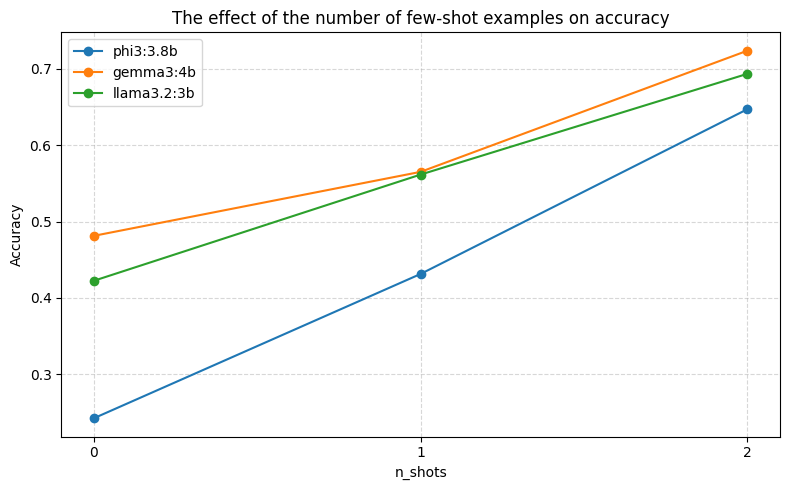

In [43]:
import matplotlib.pyplot as plt

# Данные
import pandas as pd
df = pd.DataFrame({
    'llm': [
        'phi3:3.8b', 'phi3:3.8b', 'phi3:3.8b',
        'gemma3:4b', 'gemma3:4b', 'gemma3:4b',
        'llama3.2:3b', 'llama3.2:3b', 'llama3.2:3b'
    ],
    'n_shots': [0, 1, 2, 0, 1, 2, 0, 1, 2],
    'accuracy': [
        0.242424, 0.431373, 0.647059,
        0.481283, 0.565062, 0.723708,
        0.422460, 0.561497, 0.693405
    ]
})

plt.figure(figsize=(8,5))
for llm in df['llm'].unique():
    sub = df[df['llm']==llm]
    plt.plot(sub['n_shots'], sub['accuracy'], marker='o', label=llm)

plt.xlabel('n_shots')
plt.ylabel('Accuracy')
plt.title('The effect of the number of few-shot examples on accuracy')
plt.xticks([0, 1, 2])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [16]:
!ls

Untitled.ipynb                     diagnosis_llama3.2:3b_fewshot1.csv
dataset                            diagnosis_llama3.2:3b_fewshot2.csv
diagnosis_fewshot_summary.csv      diagnosis_phi3:3.8b_fewshot0.csv
diagnosis_gemma3:4b_fewshot0.csv   diagnosis_phi3:3.8b_fewshot1.csv
diagnosis_gemma3:4b_fewshot1.csv   diagnosis_phi3:3.8b_fewshot2.csv
diagnosis_gemma3:4b_fewshot2.csv   main.py
diagnosis_llama3.2:3b_fewshot0.csv


In [27]:
import pandas as pd
from glob import glob

# Сопоставление имён файлов и параметров
file_info = [
    ('diagnosis_phi3:3.8b_fewshot0.csv',     'phi3:3.8b', 0),
    ('diagnosis_phi3:3.8b_fewshot1.csv',     'phi3:3.8b', 1),
    ('diagnosis_phi3:3.8b_fewshot2.csv',     'phi3:3.8b', 2),
    ('diagnosis_gemma3:4b_fewshot0.csv',     'gemma3:4b', 0),
    ('diagnosis_gemma3:4b_fewshot1.csv',     'gemma3:4b', 1),
    ('diagnosis_gemma3:4b_fewshot2.csv',     'gemma3:4b', 2),
    ('diagnosis_llama3.2:3b_fewshot0.csv',   'llama3.2:3b', 0),
    ('diagnosis_llama3.2:3b_fewshot1.csv',   'llama3.2:3b', 1),
    ('diagnosis_llama3.2:3b_fewshot2.csv',   'llama3.2:3b', 2),
]

all_results = []

for fname, llm, n_shots in file_info:
    df = pd.read_csv(fname)
    # Приводим к общему формату: PROMPT, ANSWER (ground truth), PREDICTED (model)
    df = df.rename(columns={col: col.lower() for col in df.columns})
    df['llm'] = llm
    df['n_shots'] = n_shots
    all_results.append(df[['prompt', 'answer', 'predicted', 'llm', 'n_shots']])

results = pd.concat(all_results, ignore_index=True)
results.rename(columns={'answer': 'true_label', 'predicted': 'pred_label'}, inplace=True)
results['true_label'] = results['true_label'].str.lower().str.strip()
results['pred_label'] = results['pred_label'].str.lower().str.strip()

In [28]:
# Считаем ошибки
errors = results[results['true_label'] != results['pred_label']]
# Сколько ошибок на каждую пару (true, predicted) по модели и n_shots
err_stat = (
    errors.groupby(['llm', 'n_shots', 'true_label', 'pred_label'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)
# Топ ошибок по каждой модели и числу шотов
print(err_stat.head(15))


             llm  n_shots        true_label            pred_label  count
47     gemma3:4b        0      hypertension              migraine     29
199  llama3.2:3b        0      hypertension              migraine     29
683    phi3:3.8b        1           malaria                dengue     29
331    phi3:3.8b        0              acne              impetigo     28
212  llama3.2:3b        0         pneumonia      bronchial asthma     27
10     gemma3:4b        0  bronchial asthma             pneumonia     27
348    phi3:3.8b        0         arthritis  cervical spondylosis     26
257  llama3.2:3b        1  fungal infection             psoriasis     25
679    phi3:3.8b        1      hypertension              migraine     24
63     gemma3:4b        1  bronchial asthma             pneumonia     23
355    phi3:3.8b        0  bronchial asthma             pneumonia     23
262  llama3.2:3b        1      hypertension              migraine     22
168  llama3.2:3b        0       common cold      br

In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Все уникальные метки (диагнозы)
label_list = sorted(results['true_label'].unique())

# Создаём папку 'results', если её ещё нет
os.makedirs('results', exist_ok=True)

for llm in results['llm'].unique():
    for n in sorted(results['n_shots'].unique()):
        subset = results[(results['llm'] == llm) & (results['n_shots'] == n)]
        
        # Строим табличку с подсчётом
        cm = pd.crosstab(
            subset['true_label'],
            subset['pred_label'],
            dropna=False
        )
        # Реиндексируем по полному списку label_list
        cm = cm.reindex(index=label_list, columns=label_list, fill_value=0)
        
        # Визуализация
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                    xticklabels=label_list, yticklabels=label_list)
        plt.xlabel("Predicted")
        plt.ylabel("True label")
        plt.title(f"Confusion Matrix: {llm}, n_shots={n}")
        plt.tight_layout()
        
        # Сохраняем картинку в папку 'results'
        fname = f"results/confusion_matrix_{llm}_n_shots_{n}.png"
        plt.savefig(fname)
        plt.close()  # Закрываем, чтобы не скапливались лишние картинки в памяти


In [45]:
for llm in results['llm'].unique():
    print(f"=== {llm} ===")
    for n in sorted(results['n_shots'].unique()):
        print(f" n_shots={n}")
        err_now = err_stat[(err_stat['llm'] == llm) & (err_stat['n_shots'] == n)]
        print(err_now.head(5)[['true_label', 'pred_label', 'count']])
    print()


=== phi3:3.8b ===
 n_shots=0
           true_label            pred_label  count
331              acne              impetigo     28
348         arthritis  cervical spondylosis     26
355  bronchial asthma             pneumonia     23
500      hypertension              migraine     19
507           malaria                dengue     13
 n_shots=1
                          true_label                              pred_label  \
683                          malaria                                  dengue   
679                     hypertension                                migraine   
705                        pneumonia                        bronchial asthma   
667  gastroesophageal reflux disease  gastroesophageal reflux disease (gerd)   
701             peptic ulcer disease  gastroesophageal reflux disease (gerd)   

     count  
683     29  
679     24  
705     19  
667     18  
701     12  
 n_shots=2
                          true_label                              pred_label  \
793 

In [31]:
# Примеры ошибок для phi3:3.8b, n_shots=0
example_errors = errors[(errors['llm'] == 'phi3:3.8b') & (errors['n_shots'] == 0)]
print(example_errors[['prompt', 'true_label', 'pred_label']].head())


                                              prompt true_label pred_label
0  Patient description: I just developed a really...       acne   impetigo
1  Patient description: I've recently been battli...       acne   impetigo
2  Patient description: I awoke this morning to s...       acne   impetigo
3  Patient description: My skin has simply nonher...       acne   impetigo
4  Patient description: I've been dealing with a ...       acne   impetigo


In [41]:
import pandas as pd

top_n = 3
error_tables = []

for llm in results['llm'].unique():
    for n in sorted(results['n_shots'].unique()):
        subset = results[(results['llm'] == llm) & (results['n_shots'] == n)]
        errors = subset[subset['true_label'] != subset['pred_label']]
        pair_counts = (
            errors.groupby(['true_label', 'pred_label'])
            .size()
            .reset_index(name='count')
            .sort_values('count', ascending=False)
            .head(top_n)
        )
        pair_counts['llm'] = llm
        pair_counts['n_shots'] = n
        error_tables.append(pair_counts)

# Объединяем всё в одну большую таблицу
top_errors_df = pd.concat(error_tables, ignore_index=True)

# Колонки выводим в нужном порядке
top_errors_df = top_errors_df[['llm', 'n_shots', 'true_label', 'pred_label', 'count']]
print(top_errors_df)

# (По желанию — сохранить в CSV)
# top_errors_df.to_csv("top_mistakes_table.csv", index=False)


            llm  n_shots                       true_label  \
0     phi3:3.8b        0                             acne   
1     phi3:3.8b        0                        arthritis   
2     phi3:3.8b        0                 bronchial asthma   
3     phi3:3.8b        1                          malaria   
4     phi3:3.8b        1                     hypertension   
5     phi3:3.8b        1                        pneumonia   
6     phi3:3.8b        2  gastroesophageal reflux disease   
7     phi3:3.8b        2                        pneumonia   
8     phi3:3.8b        2                          malaria   
9     gemma3:4b        0                     hypertension   
10    gemma3:4b        0                 bronchial asthma   
11    gemma3:4b        0             peptic ulcer disease   
12    gemma3:4b        1                 bronchial asthma   
13    gemma3:4b        1                     hypertension   
14    gemma3:4b        1            dimorphic hemorrhoids   
15    gemma3:4b        2

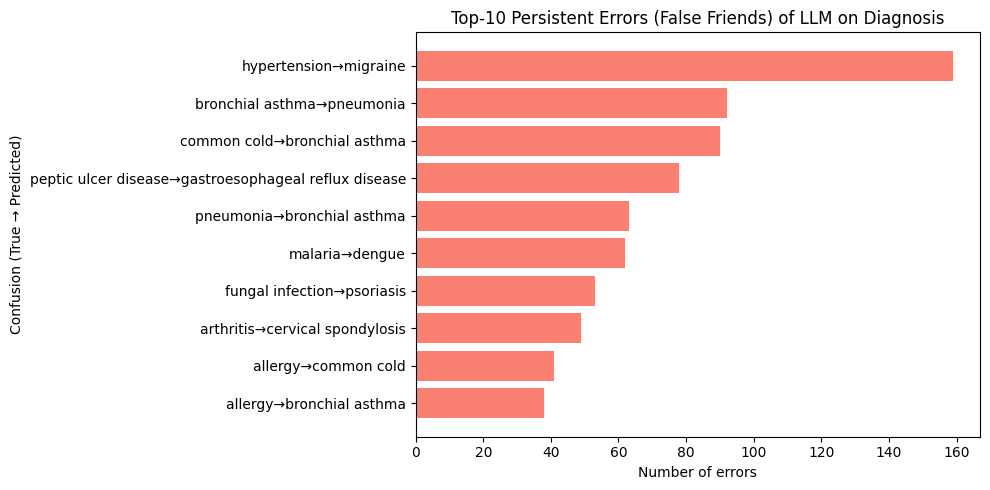

In [39]:
import matplotlib.pyplot as plt

# Группируем по (true_label, pred_label) и суммируем count по всем моделям и n_shots
summary = (top_errors_df
    .groupby(['true_label', 'pred_label'])['count']
    .sum()
    .reset_index()
    .sort_values('count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
plt.barh(
    summary.apply(lambda x: f"{x['true_label']}→{x['pred_label']}", axis=1),
    summary['count'],
    color='salmon'
)
plt.xlabel("Number of errors")
plt.ylabel("Confusion (True → Predicted)")
plt.title("Top-10 Persistent Errors (False Friends) of LLM on Diagnosis")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
